In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


encabezados_corrientes = pd.read_csv('corrientes.csv', nrows=0).columns
encabezados_potencias = pd.read_csv('potencias.csv', nrows=0).columns

fila_inicio = 1
#numero_filas = 90500  # Número de filas que deseas cargar
numero_filas = 120000
# Leer el CSV seleccionando el rango de filas específico
corrientes = pd.read_csv('corrientes.csv', skiprows=fila_inicio, nrows=numero_filas, header=None, names=encabezados_corrientes)
potencias = pd.read_csv('potencias.csv', skiprows=fila_inicio, nrows=numero_filas, header=None, names=encabezados_potencias)



# Convertir la columna 'timestamp' a datetime
corrientes['timestamp'] = pd.to_datetime(corrientes['timestamp'])
potencias['timestamp'] = pd.to_datetime(potencias['timestamp'])

# Unir los dataframes en base al ID y timestamp
df_unido = pd.merge(corrientes, potencias, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
df_unido['año'] = df_unido['timestamp'].dt.year
df_unido['mes'] = df_unido['timestamp'].dt.month
df_unido['dia'] = df_unido['timestamp'].dt.day
df_unido['hora'] = df_unido['timestamp'].dt.hour
df_unido['minuto'] = df_unido['timestamp'].dt.minute


#Codificación del tiempo del día
df_unido['tiempo_del_dia'] = df_unido['hora'] + df_unido['minuto'] / 60.0
df_unido['dia_sen'] = np.sin(2 * np.pi * df_unido['tiempo_del_dia'] / 24)
df_unido['dia_cos'] = np.cos(2 * np.pi * df_unido['tiempo_del_dia'] / 24)

# Codificación del día del año
df_unido['dia_del_año'] = df_unido['timestamp'].dt.dayofyear
df_unido['mes_sen'] = np.sin(2 * np.pi * df_unido['dia_del_año'] / 365)
df_unido['mes_cos'] = np.cos(2 * np.pi * df_unido['dia_del_año'] / 365)

# Seleccionar y reorganizar las columnas en el formato deseado
final_df = df_unido[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3','dia_sen','dia_cos', 'mes_sen', 'mes_cos']]


In [62]:
import numpy as np

def add_noise_to_sequence(sequence, noise_level=0.1):
    """
    Adds Gaussian noise to a sequence of numerical data.

    Parameters:
    - sequence (np.array or list): The input sequence (e.g., a list of numbers or a numpy array).
    - noise_level (float): The standard deviation of the Gaussian noise to be added.
                           A higher value means more noise.

    Returns:
    - np.array: The sequence with added noise.
    """
    # Convert the input sequence to a numpy array if it isn't already
    sequence = np.array(sequence)
    
    # Generate Gaussian noise
    noise = np.random.normal(loc=0.0, scale=noise_level, size=sequence.shape)
    
    # Add the noise to the sequence
    noisy_sequence = sequence + noise
    
    return noisy_sequence

# Example usage
original_sequence = np.array([1.0, 2.0, 3.0, 4.0, 5.0])
noisy_sequence = add_noise_to_sequence(original_sequence, noise_level=0.2)

print("Original Sequence:", original_sequence)
print("Noisy Sequence:", noisy_sequence)

Original Sequence: [1. 2. 3. 4. 5.]
Noisy Sequence: [0.8303981  2.26118127 3.18484159 4.12808236 4.7890526 ]


In [84]:
df_train = final_df[0:5000]
df_val = final_df[5001:6050]
df_test = final_df[6051:7200]

In [4]:
import itertools

# Crear la secuencia base
secuencia_base = [1, 2, 0, 4, 5]

# Usar itertools.cycle para repetir la secuencia
secuencia_repetida = list(itertools.islice(itertools.cycle(secuencia_base), 20))

print(secuencia_repetida)

[1, 2, 0, 4, 5, 1, 2, 0, 4, 5, 1, 2, 0, 4, 5, 1, 2, 0, 4, 5]


In [61]:
import numpy as np

def crear_ventana(dataset, ventana):
    X = []
    y = []

    # Crear ventanas y calcular el valor objetivo
    for i in range(len(dataset) - ventana):
        # Crear la ventana
        window = dataset.iloc[i:i+ventana].copy()

        # Características de la ventana
        window_features = window[['activa','dia_sen', 'dia_cos', 'mes_sen', 'mes_cos']].values
        
        # El valor objetivo es el valor de 'activa' en el tiempo t+1
        target_value = dataset.iloc[i+ventana]['activa']

        X.append(window_features)
        y.append(target_value)

    # Convertir las listas a arrays de NumPy para facilitar su uso
    X = np.array(X)
    y = np.array(y)
    X = add_noise_to_sequence(X, noise_level=0.2)


    return X, y


In [6]:
def crear_ventana2(dataset, ventana):
    X = []
    y = []

    # Crear ventanas y calcular el valor objetivo
    for i in range(0, len(dataset) - ventana, ventana):
        # Crear la ventana
        window_features = dataset[i:i+ventana]

        # El valor objetivo es el valor en el tiempo t+1
        target_value = dataset[i+ventana]

        X.append(window_features)
        y.append(target_value)

    # Convertir las listas a arrays de NumPy para facilitar su uso
    X = np.array(X)
    y = np.array(y)

    return X, y

In [136]:
t = 4*24*7
Xtrain, ytrain = crear_ventana(df_train, t)
Xval, yval = crear_ventana(df_val, t)
Xtest, ytest = crear_ventana(df_test, t)

In [137]:
Xtrain[1]

array([[ 1.23376114e+01,  2.50468900e-02,  1.06157613e+00,
         2.76981208e-03,  1.00813787e+00],
       [ 1.20358608e+01,  2.37592823e-01,  1.21127232e+00,
         3.50454779e-03,  1.10701398e+00],
       [ 1.30670353e+01, -4.64281019e-02,  1.05314992e+00,
         1.63003971e-01,  6.72919976e-01],
       ...,
       [ 1.28209184e+01, -4.50500367e-01,  1.14156866e+00,
        -1.87926012e-01,  1.00361373e+00],
       [ 1.22151050e+01, -1.73545520e-02,  9.99857570e-01,
         7.59072244e-02,  9.88842630e-01],
       [ 1.31041801e+01,  4.05505882e-02,  1.22561169e+00,
        -1.00622199e-01,  5.02308088e-01]])

In [138]:
ytrain[1]

13.068

In [10]:
Xtrain[10,:,:]

array([[12.696     ,  0.60876143,  0.79335334,  0.01721336,  0.99985184],
       [12.684     ,  0.65934582,  0.75183981,  0.01721336,  0.99985184],
       [12.612     ,  0.70710678,  0.70710678,  0.01721336,  0.99985184],
       [13.164     ,  0.75183981,  0.65934582,  0.01721336,  0.99985184]])

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaleractiva = MinMaxScaler()
scalerreactiva = MinMaxScaler()
scaleraparente = MinMaxScaler()
scalercosdia = MinMaxScaler()
scalersendia = MinMaxScaler()
scalercoshora = MinMaxScaler()
scalersenhora = MinMaxScaler()
scalerl1 = MinMaxScaler()
scalerl2 = MinMaxScaler()
scalerl3 = MinMaxScaler()
scalermedia = MinMaxScaler()
scalervar = MinMaxScaler()
scalerdesv = MinMaxScaler()
salidas = MinMaxScaler()
diferencias = MinMaxScaler()
#final_df = final_df[['activa', 'aparente', 'reactiva', 'l1', 'l2', 'l3','dia_sen','dia_cos', 'mes_sen', 'mes_cos']]

Xtrain_n = Xtrain.copy()

#X[:, :, 0] = scalerano.fit_transform(X[:, :, 0])
#X[:, :, 1] = scalermes.fit_transform(X[:, :, 1])
#X[:, :, 2] = scalerdia.fit_transform(X[:, :, 2])
#X[:, :, 3] = scalerhora.fit_transform(X[:, :, 3])
#X[:, :, 4] = scalerminuto.fit_transform(X[:, :, 4])
#X[:, :, 5] = scaleractiva.fit_transform(X[:, :, 5])
Xtrain_n[:, :, 0] = scaleractiva.fit_transform(Xtrain[:, :, 0])
Xtrain_n[:, :, 1] = scalersenhora.fit_transform(Xtrain[:, :, 1])
Xtrain_n[:, :, 2] = scalercoshora.fit_transform(Xtrain[:, :, 2])
Xtrain_n[:, :, 3] = scalersendia.fit_transform(Xtrain[:, :, 3])
Xtrain_n[:, :, 4] = scalercosdia.fit_transform(Xtrain[:, :, 4])
#X_n[:, :, 0] = scalerl3.fit_transform(X[:, :, 0])
#X_n[:, :, 5] = scalermedia.fit_transform(X[:, :, 5])
#X_n[:, :, 6] = scalerdesv.fit_transform(X[:, :, 6])
#X_n[:, :, 7] = scalervar.fit_transform(X[:, :, 7])
#X_n[:,:,1] = diferencias.fit_transform(X[:, :, 1])

In [140]:

Xval_n = Xval.copy()

#X[:, :, 0] = scalerano.fit_transform(X[:, :, 0])
#X[:, :, 1] = scalermes.fit_transform(X[:, :, 1])
#X[:, :, 2] = scalerdia.fit_transform(X[:, :, 2])
#X[:, :, 3] = scalerhora.fit_transform(X[:, :, 3])
#X[:, :, 4] = scalerminuto.fit_transform(X[:, :, 4])
#X[:, :, 5] = scaleractiva.fit_transform(X[:, :, 5])
Xval_n[:, :, 0] = scaleractiva.transform(Xval[:, :, 0])
Xval_n[:, :, 1] = scalersenhora.transform(Xval[:, :, 1])
Xval_n[:, :, 2] = scalercoshora.transform(Xval[:, :, 2])
Xval_n[:, :, 3] = scalersendia.transform(Xval[:, :, 3])
Xval_n[:, :, 4] = scalercosdia.transform(Xval[:, :, 4])
#X_n[:, :, 1] = scaleraparente.fit_transform(X[:, :, 1])
#X_n[:, :, 2] = scalerreactiva.fit_transform(X[:, :, 2])
#X_n[:, :, 3] = scalerl1.fit_transform(X[:, :, 3])
#X_n[:, :, 4] = scalerl2.fit_transform(X[:, :, 4])
#X_n[:, :, 0] = scalerl3.fit_transform(X[:, :, 0])
#X_n[:, :, 5] = scalermedia.fit_transform(X[:, :, 5])
#X_n[:, :, 6] = scalerdesv.fit_transform(X[:, :, 6])
#X_n[:, :, 7] = scalervar.fit_transform(X[:, :, 7])
#X_n[:,:,1] = diferencias.fit_transform(X[:, :, 1])

In [141]:

Xtest_n = Xtest.copy()

#X[:, :, 0] = scalerano.fit_transform(X[:, :, 0])
#X[:, :, 1] = scalermes.fit_transform(X[:, :, 1])
#X[:, :, 2] = scalerdia.fit_transform(X[:, :, 2])
#X[:, :, 3] = scalerhora.fit_transform(X[:, :, 3])
#X[:, :, 4] = scalerminuto.fit_transform(X[:, :, 4])
#X[:, :, 5] = scaleractiva.fit_transform(X[:, :, 5])
Xtest_n[:, :, 0] = scaleractiva.transform(Xtest[:, :, 0])
Xtest_n[:, :, 1] = scalersenhora.transform(Xtest[:, :, 1])
Xtest_n[:, :, 2] = scalercoshora.transform(Xtest[:, :, 2])
Xtest_n[:, :, 3] = scalersendia.transform(Xtest[:, :, 3])
Xtest_n[:, :, 4] = scalercosdia.transform(Xtest[:, :, 4])
#X_n[:, :, 1] = scaleraparente.fit_transform(X[:, :, 1])
#X_n[:, :, 2] = scalerreactiva.fit_transform(X[:, :, 2])
#X_n[:, :, 3] = scalerl1.fit_transform(X[:, :, 3])
#X_n[:, :, 4] = scalerl2.fit_transform(X[:, :, 4])
#X_n[:, :, 0] = scalerl3.fit_transform(X[:, :, 0])
#X_n[:, :, 5] = scalermedia.fit_transform(X[:, :, 5])
#X_n[:, :, 6] = scalerdesv.fit_transform(X[:, :, 6])
#X_n[:, :, 7] = scalervar.fit_transform(X[:, :, 7])
#X_n[:,:,1] = diferencias.fit_transform(X[:, :, 1])

In [142]:
ytest = ytest.reshape(-1,1)
ytrain = ytrain.reshape(-1,1)
yval = yval.reshape(-1,1)



ytest_n = ytest.copy()
ytrain_n = ytrain.copy()
yval_n = yval.copy()


ytrain_n = salidas.fit_transform(ytrain)
yval_n = salidas.transform(yval)
ytest_n = salidas.transform(ytest)



In [143]:
import numpy as np
import pandas as pd
import json
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, BatchNormalization, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import RMSprop

# Asegurar reproducibilidad
np.random.seed(47)
tf.random.set_seed(47)
initializer = GlorotUniform(seed=47)

# Define los intervalos y los valores de learning rate
boundaries = [3, 5, 7, 10, 15, 20]  # Los límites de los intervalos (épocas en este caso)
values = [0.02, 0.025, 0.005, 0.001, 0.0005, 0.0001, 0.00005]  # Learning rates correspondientes a los intervalos

# Crea el scheduler de learning rate
lr_schedule = PiecewiseConstantDecay(
    boundaries=boundaries,
    values=values
)


# Crear el modelo LSTM
model = Sequential()

model.add(Bidirectional(LSTM(100, return_sequences=True, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), kernel_initializer=initializer)))
model.add(Dropout(0.1))
#model.add(BatchNormalization())
model.add(Bidirectional(LSTM(50, return_sequences=False, kernel_initializer=initializer)))
model.add(Dense(50, kernel_initializer=initializer))
model.add(Dense(1, kernel_initializer=initializer,activation='linear'))


# Compilar el modelo con el optimizador personalizado
optimizer = Adam(learning_rate=lr_schedule, clipnorm=1)
#optimizer = RMSprop(learning_rate=lr_schedule, clipnorm=1)


model.compile(optimizer=optimizer, loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# Entrenar el modelo con datos de validación y EarlyStopping
model.fit(Xtrain_n, ytrain_n, epochs=250, verbose=1, batch_size=64,
           validation_data = (Xval_n,yval_n) , callbacks=[early_stopping])



Epoch 1/250
68/68 [==============================] - 190s 3s/step - loss: 1.0552 - val_loss: 0.0324
Epoch 2/250
68/68 [==============================] - 189s 3s/step - loss: 0.0242 - val_loss: 0.0230
Epoch 3/250
68/68 [==============================] - 193s 3s/step - loss: 0.0142 - val_loss: 0.0144
Epoch 4/250
68/68 [==============================] - 188s 3s/step - loss: 0.0109 - val_loss: 0.0133
Epoch 5/250
68/68 [==============================] - 180s 3s/step - loss: 0.0088 - val_loss: 0.0107
Epoch 6/250
68/68 [==============================] - 179s 3s/step - loss: 0.0080 - val_loss: 0.0115
Epoch 7/250
68/68 [==============================] - 179s 3s/step - loss: 0.0065 - val_loss: 0.0063
Epoch 8/250
68/68 [==============================] - 181s 3s/step - loss: 0.0058 - val_loss: 0.0061
Epoch 9/250
68/68 [==============================] - 180s 3s/step - loss: 0.0052 - val_loss: 0.0057
Epoch 10/250
68/68 [==============================] - 210s 3s/step - loss: 0.0048 - val_loss: 0.0057

In [144]:
Xtrain.shape

(4328, 672, 5)

In [145]:
prediccionesval = model.predict(Xval_n)
prediccionestest = model.predict(Xtest_n)

15/15 [==============================] - 6s 410ms/step


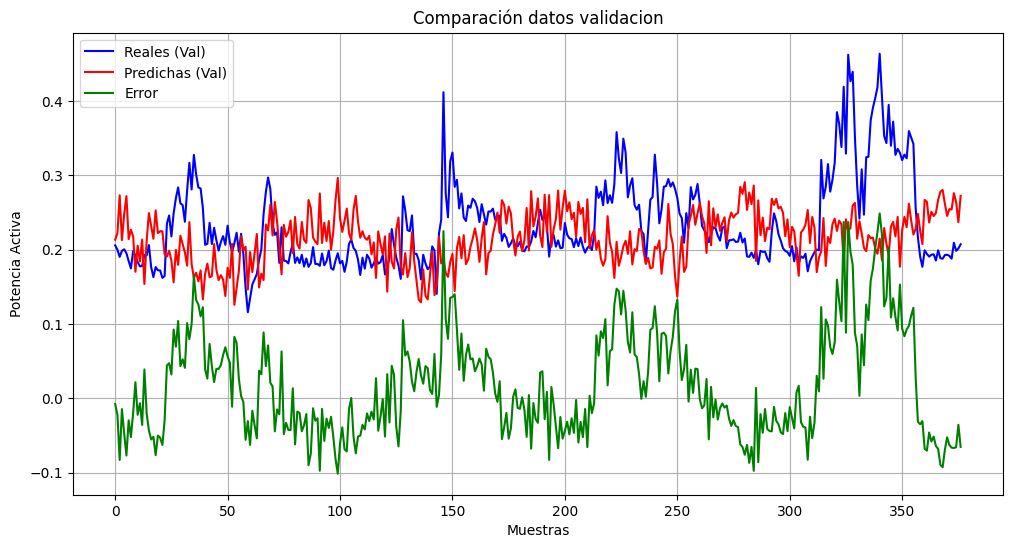

In [146]:
inicio = 00
fin = 500

plt.figure(figsize=(12, 6))
error = yval_n - prediccionesval

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(yval_n[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionesval[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos validacion')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)


In [117]:
Xtrain.shape

(4900, 100, 5)

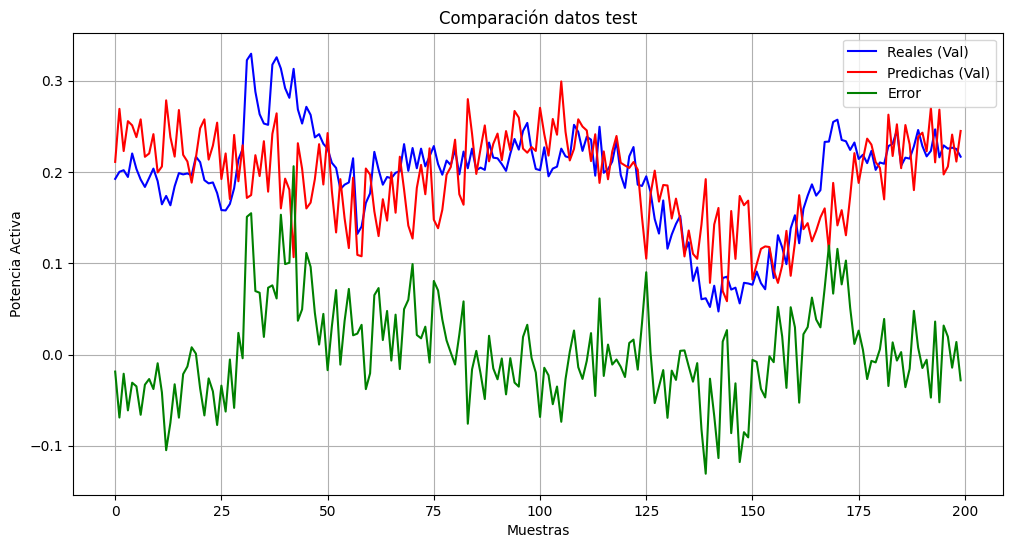

In [147]:
inicio = 000
fin = 200

plt.figure(figsize=(12, 6))
error = ytest_n - prediccionestest

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ytest_n[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionestest[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos test')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)


In [148]:
prediccionestest_desn = salidas.inverse_transform(prediccionestest)
prediccionesval_desn = salidas.inverse_transform(prediccionesval)

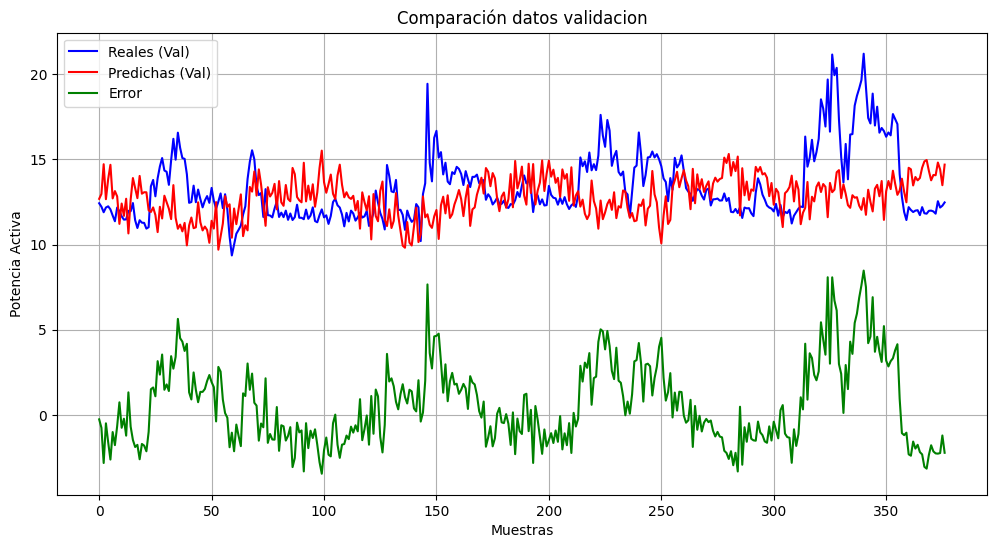

In [149]:
inicio = 00
fin = 3300

plt.figure(figsize=(12, 6))
error = yval - prediccionesval_desn

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(yval[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionesval_desn[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos validacion')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)


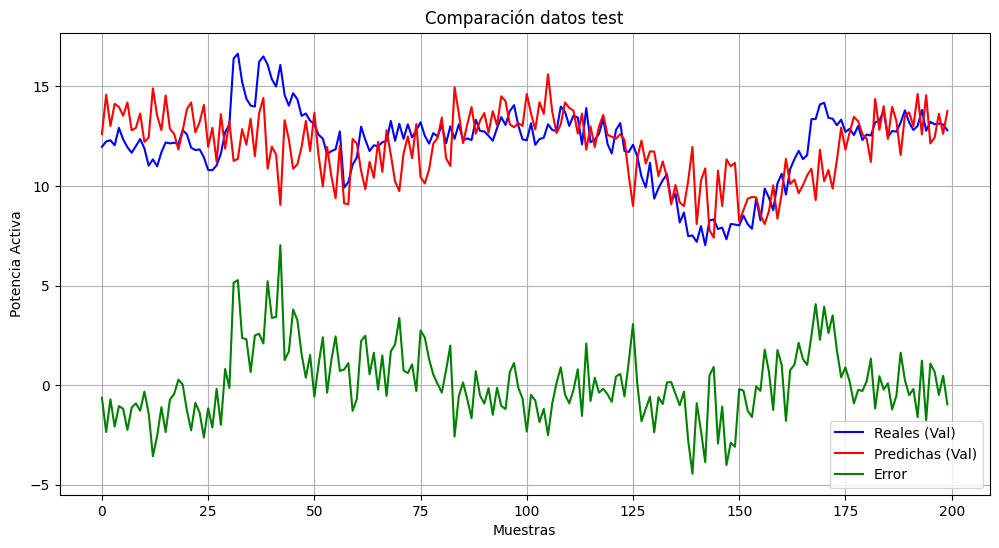

In [150]:
inicio = 000
fin = 200

plt.figure(figsize=(12, 6))
error = ytest - prediccionestest_desn

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ytest[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionestest_desn[inicio:fin], label='Predichas (Val)', linestyle='-', color='red')
plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos test')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

In [152]:
prediccionestrain = model.predict(Xtrain_n)
prediccionestrain = salidas.inverse_transform(prediccionestrain)

136/136 [==============================] - 59s 431ms/step


In [29]:
a =model.evaluate(Xtrain_n)

2969/2969 [==============================] - 9s 3ms/step - loss: 0.0000e+00


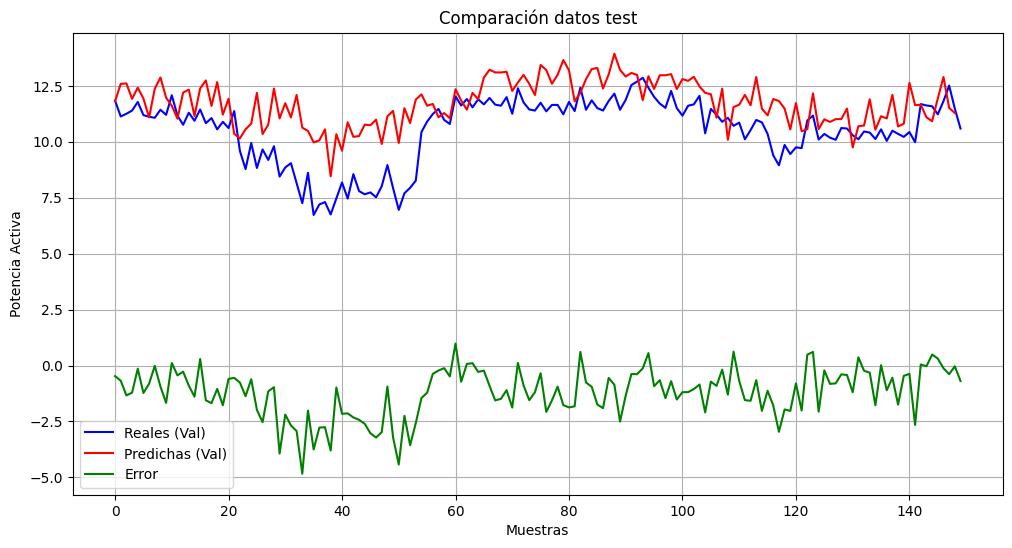

In [166]:
inicio =2800
fin = 2950

plt.figure(figsize=(12, 6))
error = ytrain - prediccionestrain

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ytrain[inicio:fin], label='Reales (Val)', linestyle='-', color='blue')
plt.plot(prediccionestrain[inicio+1:fin], label='Predichas (Val)', linestyle='-', color='red')
plt.plot(error[inicio:fin], label='Error', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación datos test')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

In [7]:
# Leer los CSV a partir de la fila 117207 (recordar que skiprows es 0-based)

# Leer los encabezados del archivo
encabezados_corrientes = pd.read_csv('corrientes.csv', nrows=0).columns
encabezados_potencias = pd.read_csv('potencias.csv', nrows=0).columns

#corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=117206, header=None, names=encabezados_corrientes)
#print(corrientes_nuevas)
#potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=117206, header=None, names=encabezados_potencias)
corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=117206, header=None, names=encabezados_corrientes)
potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=117206, header=None, names=encabezados_potencias)
#fila_inicio = 117206  # Índice de la primera fila que deseas cargar
fila_inicio = 500
numero_filas = 4149  # Número de filas que deseas cargar

# Leer el CSV seleccionando el rango de filas específico
corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=fila_inicio, nrows=numero_filas, header=None, names=encabezados_corrientes)
potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=fila_inicio, nrows=numero_filas, header=None, names=encabezados_potencias)



# Convertir la columna 'timestamp' a datetime
corrientes_nuevas['timestamp'] = pd.to_datetime(corrientes_nuevas['timestamp'])
potencias_nuevas['timestamp'] = pd.to_datetime(potencias_nuevas['timestamp'])

# Unir los dataframes en base al ID y timestamp
df_unido = pd.merge(corrientes_nuevas, potencias_nuevas, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
df_unido['año'] = df_unido['timestamp'].dt.year
df_unido['mes'] = df_unido['timestamp'].dt.month
df_unido['dia'] = df_unido['timestamp'].dt.day
df_unido['hora'] = df_unido['timestamp'].dt.hour
df_unido['minuto'] = df_unido['timestamp'].dt.minute

# Seleccionar y reorganizar las columnas en el formato deseado
df_nuevo = df_unido[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3']]

# Mostrar el dataframe resultante
print(df_nuevo)

       año  mes  dia  hora  minuto  activa  reactiva  aparente     l1     l2  \
0     2021    1    6     4      45  12.732     9.564    15.924  27.93  24.51   
1     2021    1    6     5       0  11.880    10.284    15.712  27.00  24.03   
2     2021    1    6     5      15  12.552     9.564    15.780  26.91  24.45   
3     2021    1    6     5      30  12.552     9.324    15.636  27.06  24.12   
4     2021    1    6     5      45  12.240     9.456    15.468  27.03  23.52   
...    ...  ...  ...   ...     ...     ...       ...       ...    ...    ...   
4144  2021    2   18     8      45  12.540     7.980    14.864  29.34  22.38   
4145  2021    2   18     9       0  14.472     6.204    15.744  29.25  25.32   
4146  2021    2   18     9      15  14.268     6.468    15.664  29.07  25.17   
4147  2021    2   18     9      30  13.272     6.588    14.816  31.38  21.63   
4148  2021    2   18     9      45  12.504     6.300    14.000  29.25  21.57   

         l3  
0     21.90  
1     21.18